# Speech-based Emotion Recognition for Voice Comms.
## Script for batch data augmentation

In [16]:
import soundfile
import numpy as np
import math
import librosa
import glob
import os
import matplotlib.pyplot as plt
from pysndfx import AudioEffectsChain

class AugmentData:
    def read_audio_file(self, file_path):
        data = librosa.core.load(file_path, sr=None)[0]
        return data
    
    # generating new .wav files
    def write_audio_file(self, file, data, sample_rate=16000):
        librosa.output.write_wav(file, data, sample_rate)
    
    # example plots
    def plot_time_series(self, data):
        fig = plt.figure(figsize=(10, 4))
        plt.title('Raw wave ')
        plt.ylabel('Amplitude')
        plt.style.use('ggplot')
        plt.plot(np.linspace(0, 1, len(data)), data)
        plt.show()
    
    # SNR augment(white noise generation) in dB
    # given a signal and desired SNR, 
    # this gives the required AWGN what should be added to the signal to achieve desired SNR
    def add_noise(signal, snr):
        #RMS value of signal
        RMS_s = math.sqrt(np.mean(signal**2))
        #RMS values of noise
        RMS_n = math.sqrt(RMS_s**2/(pow(10,snr/20)))
        #Additive white gausian noise. Thereore mean=0
        #Because sample length is large (typically > 40000)
        #we can use the population formula for standard daviation.
        #because mean=0 STD=RMS
        STD_n = RMS_n
        noise = np.random.normal(0, STD_n, signal.shape[0])
        return noise
    
    # background noise (overlaying other voices, mechanical noise, etc.)
    # given a signal, noise (audio) and desired SNR, 
    # this gives the noise (scaled version of noise input) that gives the desired SNR
    def add_bg_noise(self,signal, noise, snr):
        RMS_s = math.sqrt(np.mean(signal**2))
        #required RMS of noise
        RMS_n = math.sqrt(RMS_s**2/(pow(10,snr/20)))

        #current RMS of noise
        RMS_n_current = math.sqrt(np.mean(noise**2))
        noise = noise * (RMS_n/RMS_n_current)
        return noise

    # reverb (decay time/wet level)
    def add_reverb(self,signal):
        # hardcoded args for batch processing
        fx = (
            AudioEffectsChain()
            .reverb(reverberance=50,
               hf_damping=50,
               room_scale=100,
               stereo_depth=100,
               pre_delay=20,
               wet_gain=0,
               wet_only=True)
        )
        
        y = fx(signal)
        return y
    
    # distortion/overdrive (clipping/nonlinear effects/mic emulation)
    def add_overdrive(self, signal):
        fx = (
            AudioEffectsChain()
            .overdrive(gain=20, colour=20)
        )
        
        y = fx(signal)
        return y

In [17]:
# Create a new instance of AugmentData class
ad = AugmentData()

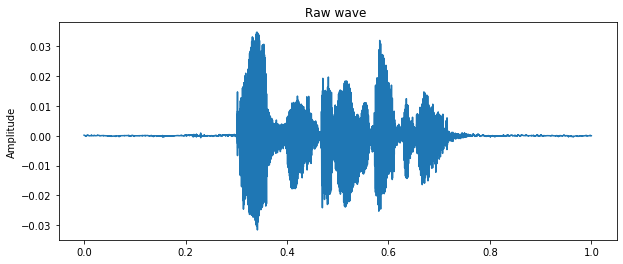

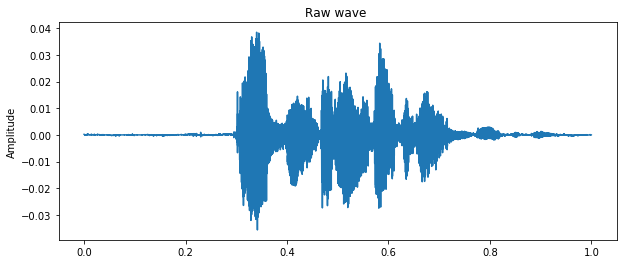

In [23]:
# RAVDESS White Noise
for file in glob.glob("data/RAVDESS/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding wn to soundfile
    data_noise = ad.add_noise(data, 20)
    datawn = data + data_noise
    
    # Write augmented soundfile wn
    ad.write_audio_file(os.path.join('data/augment-wn/RAVDESS', basename), datawn)

In [ ]:
# RAVDESS BG Noise
bgsource = ad.read_audio_file("data/augment-bg/RAVDESS/final.wav")

for file in glob.glob("data/RAVDESS/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    data = ad.read_audio_file(file)
    
    # Adding custom bg noise to soundfile
    data_background = ad.add_bg_noise(data, bgsource, 30)
    databg = data + data_background[:len(data)]

    # Write augmented soundfile bg
    ad.write_audio_file(os.path.join('data/augment-bg/RAVDESS', basename), databg)

In [11]:
# RAVDESS Reverb
for file in glob.glob("data/RAVDESS/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
data = ad.read_audio_file(file)

# Adding reverb to soundfile
data_reverb = ad.add_reverb(data)
datarev = data + data_reverb

# Write augmented soundfile reverb
ad.write_audio_file(os.path.join('data/augment-reverb/RAVDESS', basename), datarev)

In [18]:
# RAVDESS Overdrive
for file in glob.glob("data/RAVDESS/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
data = ad.read_audio_file(file)

# Simulated overdrive for soundfile
data_od = ad.add_overdrive(data)

# Write augmented soundfile reverb
ad.write_audio_file(os.path.join('data/augment-overdrive/RAVDESS', basename), data_od)

In [ ]:
#todo:
## codec compression emulation (different bitrates, simulated cutouts)
    # simulate specs of compression algorithms

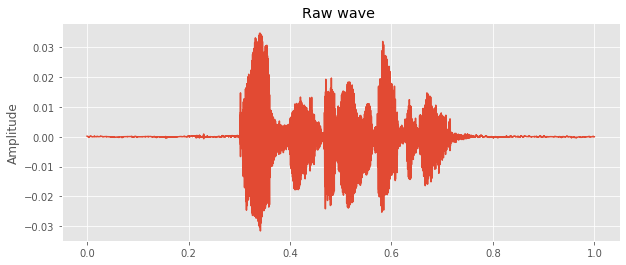

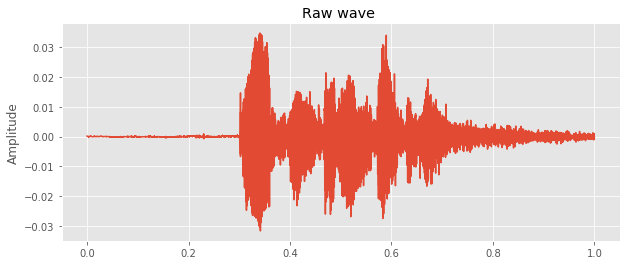

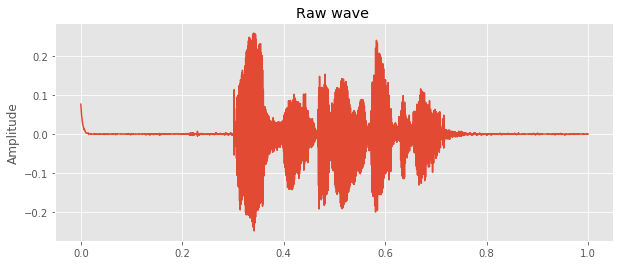

In [19]:
# plot last file in loop as example
ad.plot_time_series(data)
#ad.plot_time_series(datawn)
#ad.plot_time_series(databg)
ad.plot_time_series(datarev)
ad.plot_time_series(data_od)